In [1]:
import tensorflow_model_analysis as tfma
import ml_metadata as mlmd
from tfx import v1 as tfx
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
import pipeline_settings as settings
import pandas as pd
import tensorflow as tf

print('TF version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))
print('MLMD version: {}'.format(mlmd.__version__))


2023-02-10 10:30:44.492258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF version: 2.11.0
TFX version: 1.12.0
MLMD version: 1.12.0


In [2]:
interactive_context = InteractiveContext(
    pipeline_name=settings.PIPELINE_NAME,
    pipeline_root=settings.PIPELINE_ROOT,
    metadata_connection_config=tfx.orchestration.metadata.sqlite_metadata_connection_config(
        settings.METADATA_PATH)
)

connection_config = interactive_context.metadata_connection_config
store = mlmd.MetadataStore(connection_config)

# All TFX artifacts are stored in the base directory
base_dir = connection_config.sqlite.filename_uri.split('metadata.sqlite')[0]

In [3]:
def display_types(types):
  # Helper function to render dataframes for the artifact and execution types
  table = {'id': [], 'name': []}
  for a_type in types:
    table['id'].append(a_type.id)
    table['name'].append(a_type.name)
  return pd.DataFrame(data=table)


def display_artifacts(store, artifacts):
  # Helper function to render dataframes for the input artifacts
  table = {'artifact id': [], 'type': [], 'uri': []}
  for a in artifacts:
    table['artifact id'].append(a.id)
    artifact_type = store.get_artifact_types_by_id([a.type_id])[0]
    table['type'].append(artifact_type.name)
    table['uri'].append(a.uri.replace(base_dir, './'))
  return pd.DataFrame(data=table)


def display_properties(store, node):
  # Helper function to render dataframes for artifact and execution properties
  table = {'property': [], 'value': []}
  for k, v in node.properties.items():
    table['property'].append(k)
    table['value'].append(
        v.string_value if v.HasField('string_value') else v.int_value)
  for k, v in node.custom_properties.items():
    table['property'].append(k)
    table['value'].append(
        v.string_value if v.HasField('string_value') else v.int_value)
  return pd.DataFrame(data=table)


def get_one_hop_parent_artifacts(store, artifacts):
  # Get a list of artifacts within a 1-hop of the artifacts of interest
  artifact_ids = [artifact.id for artifact in artifacts]
  executions_ids = set(
      event.execution_id
      for event in store.get_events_by_artifact_ids(artifact_ids)
      if event.type == mlmd.proto.Event.OUTPUT)
  artifacts_ids = set(
      event.artifact_id
      for event in store.get_events_by_execution_ids(executions_ids)
      if event.type == mlmd.proto.Event.INPUT)
  return [artifact for artifact in store.get_artifacts_by_id(artifacts_ids)]


def find_producer_execution(store, artifact):
  executions_ids = set(
      event.execution_id for event in store.get_events_by_artifact_ids([artifact.id]) if event.type == mlmd.proto.Event.OUTPUT
    )
  return store.get_executions_by_id(executions_ids)[0]


In [4]:
display_types(store.get_artifact_types())

,id,name
0,15,Examples
1,17,ExampleStatistics
2,19,Schema


In [5]:
example_statistics_set = store.get_artifacts_by_type("ExampleStatistics")
display_artifacts(store, example_statistics_set)


,artifact id,type,uri
0,3,ExampleStatistics,/root/tfx_data/minst_pipeline_root/StatisticsG...
1,6,ExampleStatistics,/root/tfx_data/minst_pipeline_root/StatisticsG...
2,9,ExampleStatistics,/root/tfx_data/minst_pipeline_root/StatisticsG...
3,12,ExampleStatistics,/root/tfx_data/minst_pipeline_root/StatisticsG...


In [6]:
example_statistics = example_statistics_set[-1]
display_properties(store, example_statistics)


,property,value
0,split_names,"[""train"", ""eval""]"
1,tfx_version,1.12.0
2,is_external,0
3,state,published


In [7]:
parent_artifacts = get_one_hop_parent_artifacts(store, [example_statistics])
display_artifacts(store, parent_artifacts)


,artifact id,type,uri
0,11,Examples,/root/tfx_data/minst_pipeline_root/ImportExamp...


In [8]:
exported_dataset = parent_artifacts[0]
display_properties(store, exported_dataset)


,property,value
0,split_names,"[""train"", ""eval""]"
1,tfx_version,1.12.0
2,payload_format,FORMAT_TF_EXAMPLE
3,span,0
4,is_external,0
5,file_format,tfrecords_gzip
6,input_fingerprint,"split:single_split,num_files:1,total_bytes:597..."
7,state,published


In [9]:
display_types(store.get_execution_types())


,id,name
0,13,tfx.components.example_gen.import_example_gen....
1,16,tfx.components.statistics_gen.component.Statis...
2,18,tfx.components.schema_gen.component.SchemaGen


In [10]:
trainer = find_producer_execution(store, exported_dataset)
display_properties(store, trainer)


,property,value
0,output_config,"{\n ""split_config"": {\n ""splits"": [\n ..."
1,input_base,/tmp/tfx-datazpm6kxqa/v1.0
2,input_fingerprint,"split:single_split,num_files:1,total_bytes:597..."
3,output_file_format,5
4,input_config,"{\n ""splits"": [\n {\n ""name"": ""single..."
5,output_data_format,6
6,span,0


In [11]:
from tfx.orchestration.experimental.interactive import standard_visualizations
from tfx.orchestration.experimental.interactive import visualizations
from ml_metadata.proto import metadata_store_pb2
# Non-public APIs, just for showcase.
from tfx.orchestration.portable.mlmd import execution_lib

# TODO(b/171447278): Move these functions into the TFX library.


def get_latest_artifacts(metadata, pipeline_name, component_id):
  """Output artifacts of the latest run of the component."""
  context = metadata.store.get_context_by_type_and_name(
      'node', f'{pipeline_name}.{component_id}')
  executions = metadata.store.get_executions_by_context(context.id)
  latest_execution = max(executions,
                         key=lambda e: e.last_update_time_since_epoch)
  return execution_lib.get_output_artifacts(metadata, latest_execution.id)


# Non-public APIs, just for showcase.


def visualize_artifacts(artifacts):
  """Visualizes artifacts using standard visualization modules."""
  for artifact in artifacts:
    visualization = visualizations.get_registry().get_visualization(
        artifact.type_name)
    if visualization:
      visualization.display(artifact)


standard_visualizations.register_standard_visualizations()


In [12]:
# Non-public APIs, just for showcase.
from tfx.orchestration.metadata import Metadata
from tfx.types import standard_component_specs
import tensorflow_data_validation as tfdv

latest_statistics = store.get_artifacts_by_type("ExampleStatistics")[-1]

stats_uri = latest_statistics.uri + '/Split-train/FeatureStats.pb'
stats = tfdv.load_stats_binary(stats_uri)

lateast_schema = store.get_artifacts_by_type("Schema")[-1]
schema_uri = lateast_schema.uri + '/schema.pbtxt'
schema = tfdv.load_schema_text(schema_uri)

tfdv.validate_statistics(stats, schema)




baseline {
  feature {
    name: "image"
    type: BYTES
    presence {
      min_fraction: 1.0
      min_count: 1
    }
    shape {
      dim {
        size: 1
      }
    }
  }
  feature {
    name: "label"
    type: INT
    presence {
      min_fraction: 1.0
      min_count: 1
    }
    shape {
      dim {
        size: 1
      }
    }
  }
}
anomaly_name_format: SERIALIZED_PATH

In [13]:
tfdv.visualize_statistics(stats)


In [14]:
stats_eval_uri = latest_statistics.uri + '/Split-eval/FeatureStats.pb'
stats_eval = tfdv.load_stats_binary(stats_eval_uri)
tfdv.visualize_statistics(stats, stats_eval)


In [15]:
examples = store.get_artifacts_by_type("Examples")
display_artifacts(store, examples)


,artifact id,type,uri
0,1,Examples,/root/tfx_data/minst_pipeline_root/ImportExamp...
1,2,Examples,/root/tfx_data/minst_pipeline_root/ImportExamp...
2,5,Examples,/root/tfx_data/minst_pipeline_root/ImportExamp...
3,8,Examples,/root/tfx_data/minst_pipeline_root/ImportExamp...
4,11,Examples,/root/tfx_data/minst_pipeline_root/ImportExamp...


In [16]:
dataset_uri = examples[-1].uri + '/Split-train/data_tfrecord-00000-of-00001.gz'
tf_dataset = tf.data.TFRecordDataset(dataset_uri, compression_type='GZIP')
lengt_dataset = tf_dataset.reduce(0, lambda x,_: x+1).numpy()

print(f'Number of train examples: {lengt_dataset}')
dataset_eval_uri = examples[-1].uri + '/Split-eval/data_tfrecord-00000-of-00001.gz'
tf_dataset_eval = tf.data.TFRecordDataset(
    dataset_eval_uri, compression_type='GZIP')
lengt_dataset_eval = tf_dataset_eval.reduce(0, lambda x, _: x+1).numpy()
print(f'Number of validation examples: {lengt_dataset_eval}')


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-10 10:30:58.527718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: UNKNOWN ERROR (34)
2023-02-10 10:30:58.527872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a99aa484eb14): /proc/driver/nvidia/version does not exist
2023-02-10 10:30:58.529780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Number of train examples: 46557
Number of validation examples: 23443


{'image': FixedLenFeature(shape=[1], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None)}


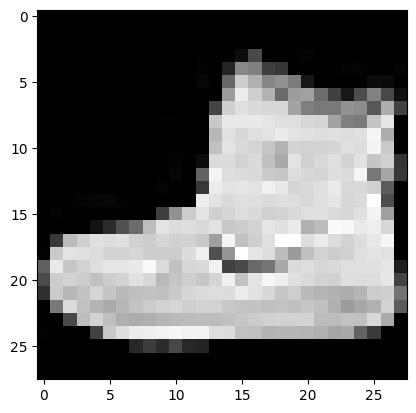


RAW FEATURES:
image: [[b'\x08\x04\x12\x08\x12\x02\x08\x1c\x12\x02\x08\x1c"\x90\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\rI\x00\x00\x01\x04\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00$\x88\x7f>6\x00\x00\x00\x01\x03\x04\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00f\xcc\xb0\x86\x90{\x17\x00\x00\x00\x00\x0c\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9b\xec\xcf\xb2k\x9c\xa1m@\x17M\x82H\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00E\xcf\xdf\xda\xd8\xd8\xa3\x7fyz\x92\x8dX\xacB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x01\x01\x00\xc8\xe8\xe8\xe9\xe5\

In [55]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow_transform.tf_metadata import schema_utils
import numpy as np

feature_spec = schema_utils.schema_as_feature_spec(schema).feature_spec
print(feature_spec)


for records in tf_dataset.batch(1).take(1):
    record = records[0]
    meh = tf.io.parse_single_example(record, feature_spec)
    im = tf.io.parse_tensor(meh["image"][0], out_type=tf.uint8)

# Create a batch from the dataset
for records in tf_dataset.batch(1).take(1):

  # Parse the batch to get a dictionary of raw features
  parsed_examples = tf.io.parse_example(records, feature_spec)
  
  record = records[0]
  raw_image = tf.io.parse_single_example(record, feature_spec)
  image = tf.io.parse_tensor(raw_image["image"][0], out_type=tf.uint8)
  plt.imshow(image, interpolation='nearest', cmap='gray')
  plt.show()

  # Print the results
  print("\nRAW FEATURES:")
  for key, value in parsed_examples.items():
    print(f'{key}: {value.numpy()}')
        


Tensor("args_0:0", shape=(), dtype=string)
{'image': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=() dtype=string>, 'label': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=() dtype=int64>}
Image shape: (28, 28)


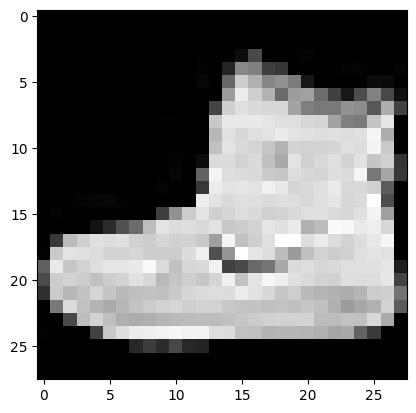

In [54]:
# Define a function to parse the `tf.train.Example` protocol buffer
def parse_fn(example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_example = tf.io.parse_single_example(example, features)
    print(example)
    print(parsed_example)
    return parsed_example


# Apply the parse function to the dataset
dataset_inspect = tf_dataset.map(parse_fn)

# one_example = next(iter(tf_dataset.take(1)))
# parsed_example = parse_fn(one_example)
# numpy_image = tf.io.parse_tensor(parsed_example["image"], out_type=tf.uint8)

# Iterate over the dataset and print the features of each example
for example in dataset_inspect.take(1):
    numpy_image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    print(f'Image shape: {numpy_image.shape}')
    plt.imshow(numpy_image, interpolation='nearest', cmap='gray')
    plt.show()
